In [1]:
%matplotlib inline
import pymysql as mdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# connect to mysql db
con = mdb.connect('localhost', 'root', '', 'RNAseq1') #host, user, password, #database

In [3]:
# connect to Clinical data
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM Clinical;")  # import file AMP-AD_ROSMAP_Rush-Broad_Clinical.csv
    rows = cur.fetchall()

# load Clinical data
colnames = tuple([desc[0] for desc in cur.description])
clin = pd.DataFrame(list(rows),columns=colnames)
clin = clin.set_index(clin.projid)
clin = clin.drop(['projid', 'ind'], axis=1)

#clin.head()

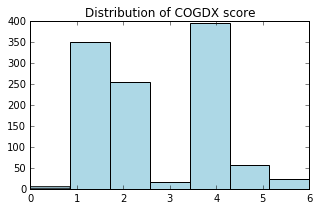

In [4]:
fig = plt.figure(1, figsize=(5, 3))
plt.hist(list(clin.cogdx),bins=7,facecolor='lightblue')
plt.title('Distribution of COGDX score')
fig.savefig('Cogdx.hist.jpg', bbox_inches='tight')
plt.show()

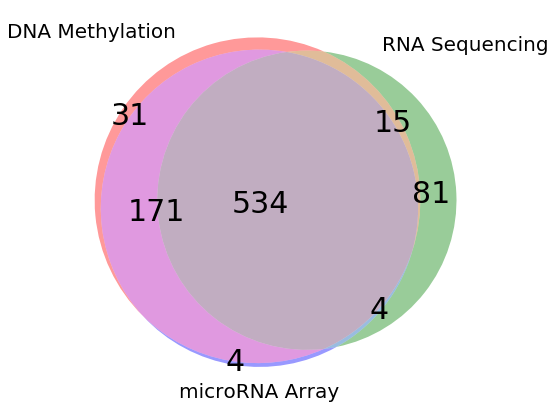

In [5]:
from matplotlib_venn import venn3
fig = plt.figure(1, figsize=(9, 7))
out = venn3(subsets = (31, 81, 15, 4, 171, 4, 534), set_labels = ('DNA Methylation', 'RNA Sequencing', 'microRNA Array'))
for text in out.set_labels:
    text.set_fontsize(20)
for text in out.subset_labels:
    text.set_fontsize(30)

fig.savefig('Samples.Venn.jpg', bbox_inches='tight')
plt.show()

# 1. Check prediction power of clinical and genetic features 

In [6]:
clin = clin.loc[clin['cogdx'].isin([1,2,4])]

test = clin.loc[:,['msex','apoe_genotype','age_death','cogdx']]
test = pd.DataFrame.replace(test,"90+",90)

In [7]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

labels = test['cogdx'].values.tolist()
bin_labels = [1 if x == 4 else 0 for x in labels]

## set train set and test set
(X_train, X_test, y_train, y_test) = train_test_split(test.loc[:,['msex','apoe_genotype','age_death']],bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set 5X crossvalidation within train set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.lda import LDA
from sklearn.metrics import roc_curve, auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [9]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))

Random Forest accuracy = 0.595


In [10]:
rf.n_estimators

400

In [11]:
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.61952087038393144

In [12]:
# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv=slo, scoring='roc_auc')

el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))

Elastic Net accuracy = 0.054265879896


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [13]:
print(el.l1_ratio)
print(el.alpha)

0
10


In [14]:
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


0.65294486871011614

In [15]:
# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))

LDA accuracy = 0.625


In [16]:
lda.solver

'svd'

In [17]:
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

0.65472329741604773

In [18]:
# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))

Logistic Regression accuracy = 0.63


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [19]:
lr.solver

'newton-cg'

In [20]:
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

0.65294486871011626

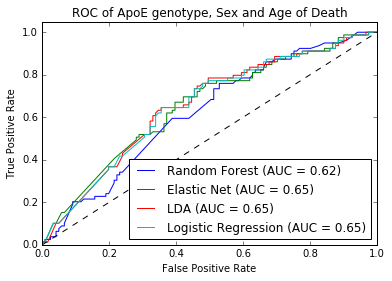

In [27]:
# Plot ROC curve
fig = plt.figure()
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of ApoE genotype, Sex and Age of Death')
plt.legend(loc="lower right")

fig.savefig('Clinical.ROC.jpg', bbox_inches='tight')
plt.show()